In [2]:
%load_ext autoreload


: 

In [3]:
%autoreload 2


In [4]:
import sys
from pathlib import Path

sys.path.append(str(Path("__file__").resolve().parent.parent))
from config import *
# from generator import *
from torchmetrics.classification import BinaryPrecision, BinaryRecall
from PIL import ImageFile
from torchvision.transforms import Normalize
import torch
from models import *
import neptune
import argparse
from tqdm import tqdm
from torchvision import transforms


import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Image patching function (non-overlapping patches)
def extract_patches(image, patch_size=(32, 32), stride=32):
    
    w, h = image.shape[0], image.shape[1]
    patches = []
    patch_positions = []
    
    for i in range(0, w - patch_size[0] + 1, stride):
        for j in range(0, h - patch_size[1] + 1, stride):
            top_left = [i,j]
            bottom_right = i + patch_size[0], j + patch_size[1]
            patch = image[top_left[0] : bottom_right[0], top_left[1] : bottom_right[1]]
            # patch = image.crop((i, j, i + patch_size[0], j + patch_size[1]))
            patches.append(patch)
            patch_positions.append((i, j))
    
    return patches, patch_positions

# Function to create a heatmap from CNN outputs
def create_heatmap(patch_predictions, patch_positions, image_size, patch_size=(32, 32), stride=32):
    heatmap = np.zeros(image_size)  # Initialize an empty heatmap
    count_map = np.zeros(image_size)  # Keep track of how many times each pixel is included in a patch
    
    # Place the predictions back into the heatmap at their respective locations
    for i, (pred, (i, j)) in enumerate(zip(patch_predictions, patch_positions)):
        # print(pred)
        top_left = [i,j]
        bottom_right = i + patch_size[0], j + patch_size[1]
        heatmap[top_left[0] : bottom_right[0], top_left[1] : bottom_right[1]] = heatmap[top_left[0] : bottom_right[0], top_left[1] : bottom_right[1]] + pred.numpy()
        count_map[top_left[0] : bottom_right[0], top_left[1] : bottom_right[1]] += 1
    
    # Normalize the heatmap by the count map (average over all patches that cover the pixel)
    heatmap /= count_map
    return heatmap


In [6]:
path_slide = path_slide_tumor_test
filenames = os.listdir(path_slide)
path_dataframe = path_dataframe_test

In [7]:
filenames[1]

'4fd800d5-4e12-43e1-b7e5-16a8abfda384.jpeg'

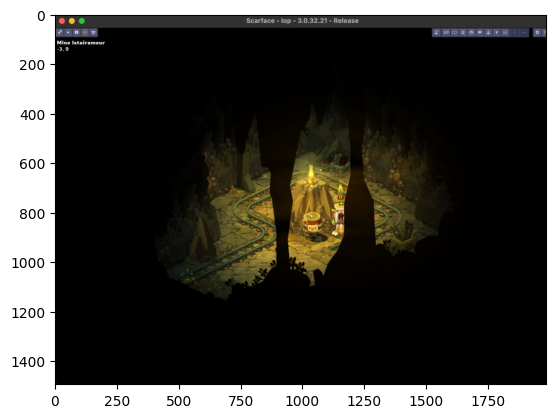

In [45]:
image = plt.imread(os.path.join(path_slide, filenames[0]))
plt.imshow(image)


In [46]:
device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example: Load an image and apply CNN on all patches

# image = plt.imread(os.path.join(path_slide, filenames[1]))

# Transform to tensor
# normalize = Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Example normalization
])

# Create CNN model
model = VGG16(vgg16(pretrained=False)).to(device)
model.load_state_dict(torch.load(os.path.join(path_weights,'weights_resnet500.1')))



<All keys matched successfully>

In [47]:
ps = 128
patches, patch_positions = extract_patches(image, patch_size=(ps, ps), stride=32)

# Process all patches
patch_predictions = []
for patch in tqdm(patches):
    # Preprocess patch and pass through CNN
    patch_tensor = transform(patch).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        # print(patch_tensor.shape)
        output = model(patch_tensor)
        # print(output)
        prob = torch.softmax(output, dim=1)  # Softmax for probabilities
        # print(prob)
        predicted_class = torch.max(prob, 1)[0].item()  # Use max probability as the prediction
        predicted_class = output
    patch_predictions.append(predicted_class)


100%|██████████| 2537/2537 [05:40<00:00,  7.45it/s]


tensor([[1.2147e-10]])
tensor([[1.0095e-07]])
tensor([[4.5345e-09]])
tensor([[2.1172e-08]])
tensor([[2.6258e-08]])
tensor([[9.3616e-08]])
tensor([[1.7029e-07]])
tensor([[1.4648e-08]])
tensor([[8.6435e-08]])
tensor([[1.6145e-07]])
tensor([[8.1037e-08]])
tensor([[1.3553e-07]])
tensor([[3.2231e-08]])
tensor([[1.6524e-07]])
tensor([[7.1927e-07]])
tensor([[6.5132e-09]])
tensor([[8.1019e-08]])
tensor([[2.8646e-08]])
tensor([[9.7040e-09]])
tensor([[2.1614e-07]])
tensor([[2.2155e-07]])
tensor([[1.5244e-07]])
tensor([[4.3086e-07]])
tensor([[3.8388e-07]])
tensor([[8.3846e-08]])
tensor([[2.1126e-07]])
tensor([[3.8660e-08]])
tensor([[8.9012e-08]])
tensor([[1.8474e-07]])
tensor([[5.0507e-08]])
tensor([[3.0306e-08]])
tensor([[1.4137e-08]])
tensor([[2.1621e-08]])
tensor([[2.1934e-07]])
tensor([[6.4362e-08]])
tensor([[1.3451e-06]])
tensor([[3.4067e-07]])
tensor([[3.7107e-08]])
tensor([[1.1373e-07]])
tensor([[3.2137e-07]])
tensor([[1.9422e-06]])
tensor([[5.7674e-07]])
tensor([[3.9078e-07]])
tensor([[9.

/var/folders/wk/s58szscn2853dmtcjy6zvr5c0000gr/T/ipykernel_27180/693398164.py:33: RuntimeWarning: invalid value encountered in divide
  heatmap /= count_map


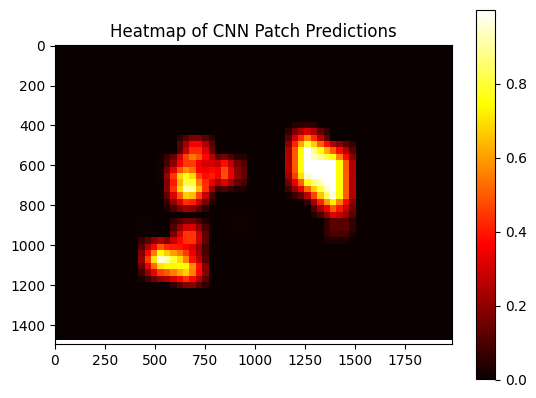

In [48]:

# Generate heatmap from patch predictions
image_size = image.shape[:-1]  # (width, height)
heatmap = create_heatmap(patch_predictions, patch_positions, image_size, patch_size=(ps, ps), stride=32)

# Visualize the heatmap
plt.imshow(heatmap, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap of CNN Patch Predictions')
plt.show()

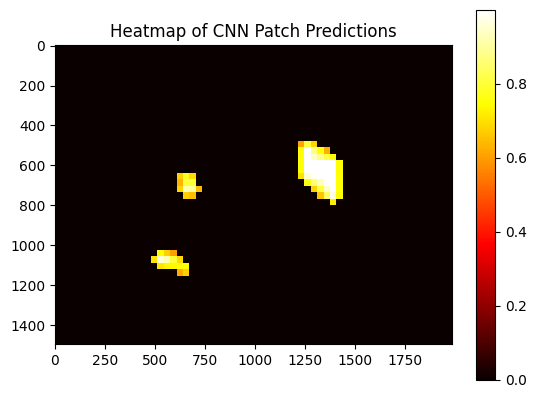

In [58]:
threshold = 0.6

heatmap_treshold = np.zeros(heatmap.shape)
heatmap_treshold[heatmap > threshold] = heatmap[heatmap > threshold]

plt.imshow(heatmap_treshold, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Heatmap of CNN Patch Predictions')
plt.show()

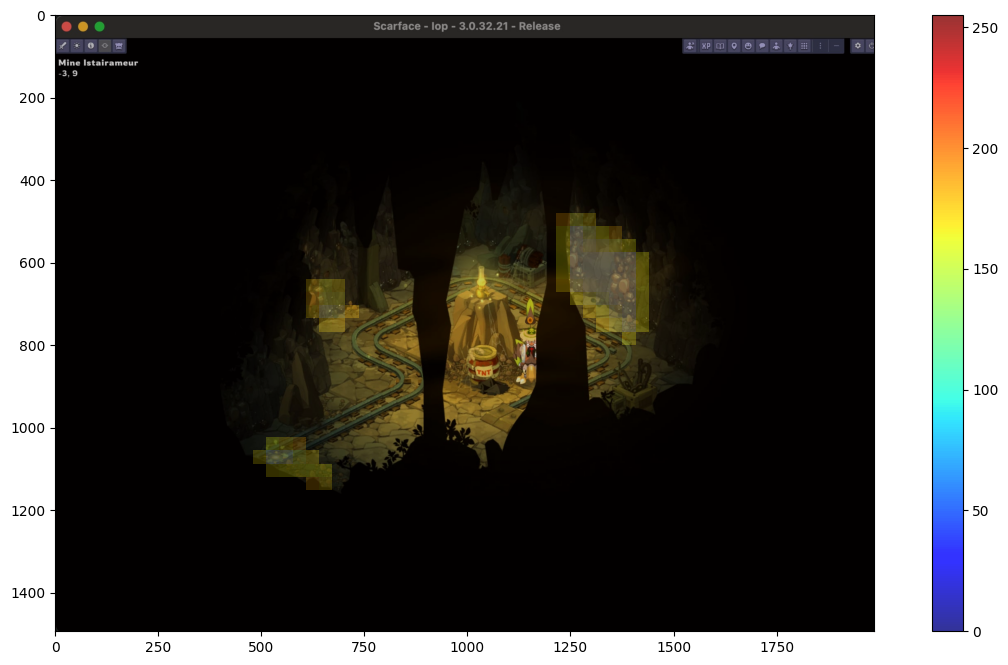

In [59]:
plt.figure(figsize=(15,8))
plt.imshow(heatmap_treshold, cmap='hot', interpolation='nearest')
plt.imshow(image, cmap='jet', alpha=0.8)
plt.colorbar()